# DCGAN with CelebA

## 1. Data

```script
chmod +x download.sh
./download.sh
unzip -q CelebA_128crop_FD.zip?dl=0 -d ./data/
```

## 2. Import Libs

In [1]:
from __future__ import print_function
import torch
import os
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as tutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)

## 3. Hyperparameters

In [3]:
IMAGE_PATH = '../input/celeba-dataset/img_align_celeba/'
SAMPLE_PATH = '../'

if not os.path.exists(SAMPLE_PATH):
    os.makedirs(SAMPLE_PATH)

In [4]:
# Number of Workers for dataloader
workers = 2

# Batch size for training
batch_size = 128

# Image size
image_size = 64

# Number of channels of image 
channels = 3

# Number of latent vectors i.e output of generator
generator_output = 100

# Size of Feature map in generator
ngf = 64

# Size of Feature map in Discriminator
ndf = 64

# Number of Epochs
num_epochs = 5

# Learning Rate 
lr = 0.0002

# Beta1 HyperParamter for Adam Optimizer 
beta1 = 0.5



## 4. Load Data

In [5]:
# Create the Dataset
dataset = datasets.ImageFolder(IMAGE_PATH, 
                             transform=transforms.Compose([
                                 transforms.Resize(image_size),
                                 transforms.CenterCrop(image_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ]))

# Create the dataloader
dataloader = tutils.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 5. Visualize Data

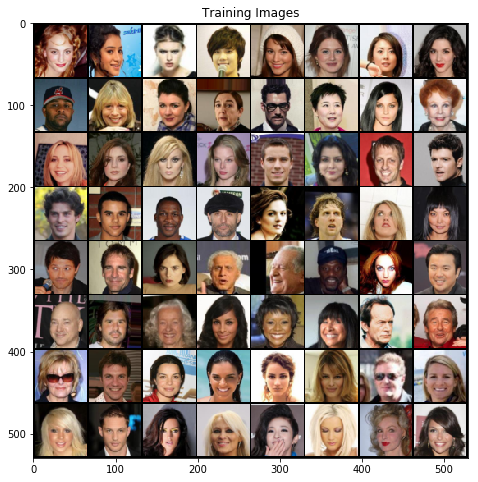

In [6]:
real_data = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_data[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## 6. Initializing Weights

In [7]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

## 7. Defining Architecture

### a) Generator

In [ ]:
class Generator(nn.Module):
    